# Q Real Boost implementation 

New boosting implementation without QRAM, and with estimation and all for conference

In [1]:
from qiskit import *
import concurrent.futures

In [2]:
import numpy as np
import pandas as pd
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from qiskit import IBMQ

# TOKEN = '14f0d3a62d85ab2df8cd73f3f81ce48dfb99526e83b946755d16a0ab451357fc886cee8a704a5256fb1e6849c8f186d74edf47501bc3239266c68e86bae7076b'

# IBMQ.save_account(TOKEN)
# IBMQ.load_account() # Load account from disk
# IBMQ.providers()    # List all available providers
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()
# backend = provider.get_backend('simulator_mps')

from sklearn.cluster import KMeans

In [3]:
# backend = Aer.get_backend('aer_simulator_matrix_product_state')
# # Aer.backends()

In [4]:
import time

In [5]:
import math
# from QAA_lib import Amplitude_Amplification
from EstAmp_lib_qiskit_parallel_parmeet import EstAmp, G_itr, get_amp

In [6]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np

### Helper functions

In [7]:
def flip_string(x):
    return x[::-1]

In [8]:
def check_j():
    
    j_i = QuantumRegister(2,'j_i')
    k = QuantumRegister(2, 'k')
    qq = QuantumRegister(2, 'qq')
    i_1 = QuantumRegister(1,'i_1')

    qc = QuantumCircuit(j_i, k, qq, i_1, name = 'label j')
    
    qc.x(j_i[0])
    qc.x(j_i[1])
    
    qc.cx(j_i[0] ,k[0])
    qc.cx(j_i[1] ,k[1])
    
    qc.cx(k[0],qq[0])
    qc.cx(k[1],qq[1])

    qc.ccx(qq[0],qq[1],i_1)

#     qc.cx(j_i[0] ,k[0])
#     qc.cx(j_i[1] ,k[1])
    
#     qc.x(j_i[0])
#     qc.x(j_i[1])
    
    return qc

In [9]:
def check_y():
    
    y = QuantumRegister(1,'j_i')
    b = QuantumRegister(1, 'b')
    i_2 = QuantumRegister(1,'i_2')

    qc = QuantumCircuit(b,y, i_2, name = 'check y')

    qc.cx(y, b)
    qc.cx(b, i_2)
    qc.x(i_2)
    
#     qc.cx(y, b)
    
    return qc

#### Initialisation of values of K and b

When we store 2 it stores in the form $q_1 q_0$ = 1 0. So normal binary form of the decimal value in the opposite of qiskit order. 

Note - make sure to encode the $j^t_i$ in the same way, while making the Oh.

In [10]:
def new_qc( mc, data):
    
    qr_m = QuantumRegister(mc)
    #cr = ClassicalRegister(2)
    
    
    qc = QuantumCircuit(qr_m, name = 'init')
    
    ## each of data points should be smaller than 2**mc
    
    for i in range(0,len(data)):
        if data[i]>2**mc:
            print("Error!! The value of the data to be stored is bigger then the 2**mc")
            return
    
    bin_data = ["" for x in range(len(data))]
    ## the data needs to convert to binary from decimal
    for i in range(0,len(data)):
        bin_data[i] = decimalToBinary(data[i], mc)
        
    
    new_data = np.zeros([len(data), mc])
    
    # now we will be dividing all our divided
    for i in range(len(data)):
        for j in range(mc):
            new_data[i, j] = bin_data[i][j]
    
    ## fliping the matrix around so the ordering is proper according QISKIT
    flip_new_data = np.flip(new_data,1)
    ## this will be arranged in a row vector so that we can run a loop over it 
    new_data_row = np.reshape(flip_new_data,[1,mc*len(data)])
    
    for i in range(len(new_data_row[0])):
        if new_data_row[0,i] == 1:
            qc.x(qr_m[i])
            
    return qc

In [11]:
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

## for convertign from decimal to binary 
def decimalToBinary(n,no_of_places):
    num = no_of_places ## this will be equal to mc
    binary = bin(n).replace("0b", "")
    if (len(binary) != num):
        i = num - len(binary)
        for j in range(0,i):
            binary = numConcat(0,binary)

    return binary

In [12]:
def dec_to_bin(n, size):
    bin_num = '0'*size
    b = bin(int(n)).replace("0b", "" )
    l = len(b)
    bin_num = bin_num[:size-l] + b
    return bin_num

In [13]:
def f2bin(number,places): 
  

  if(type(number)==int ):
    return bin(number).lstrip("0b") + "."+"0"*places

  else:
    whole, dec = str(number).split(".") 

    whole = int(whole)

    dec = "0."+dec
    
    stri = ''
  
    res = bin(whole).lstrip("0b") + "."
    
    dec= float(dec)
    
    dec_val2 = dec
    
    num = dec
    
    countlen= 0
    
    while(dec_val2 != 0 and countlen <= places):
        
        num = float(num)*2
#         print(num)
        arr = str(num).split(".")
        
        if (len(arr)==2):
            whole1 = arr[0]
            dec_val = arr[1]
        else:
            whole1 = arr[0]
            dec_val = '0'
        
        if whole1 == '0':
            stri = stri + '0'
        else:
            stri = stri+ '1'

#         print(dec_val)
        dec_val2 = float(dec_val)
        num = '0.'+dec_val
#         print(num)

        countlen = len(stri)
    
    if (len(stri)<= places):
        stri = stri + '0'*(places - len(stri))
    elif(len(stri)>= places):
        stri = stri[:places]
    else:
        stri = stri
        
    s = bin(whole)+'.'+stri
    
    return s

#### Conditional Rotations

The function given below is used to do conditional rotations. 

In [14]:
def rot_circuit():
    
    theta = np.pi
    num_qubits = 5
    qc = QuantumCircuit(num_qubits, name = 'rot_circuit')
    qc.cry(theta/2,0,4)
    qc.cry(theta/4,1,4)
    qc.cry(theta/8,2,4)
    qc.cry(theta/16,3,4)
#     qc.cry(theta/32,4,7)
#     qc.cry(theta/64,5,7)
#     qc.cry(theta/128,6,7)
#     qc.cry(theta/256,7,8)

    return qc

# Implementation

This function inputs the Xi, Yi and Wti (Weights at particular iteration and gets the partition predictions from classifier. For now we'll use classical classifier, later we'll use Quantumone and create a seperate function for it, so that we just call these functions inside our quantum boosting algo functions and let them be generalized

In [15]:
import sklearn
from sklearn import svm

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

### Breast Cancer data set

look at sklearn documentation for more information regarding this data set!!

In [16]:
wine = datasets.load_breast_cancer()

# X = iris.data[:, :4]  # our feature vector
# parts = iris.target # partitions


# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     wine.data, wine.target, test_size=0.2, random_state=22)

train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

# we get the labels now from the label train itself

n_dim = 1
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 8
X = sample_train[:train_size]
y = label_train[:train_size]
# parts = y # now we do the partitioning using binary classification  


## testing data 
test_size = 8
X_test = sample_train[train_size:train_size + test_size]
y_test = label_train[train_size:train_size + test_size]
# print(X)

### Testing 

I will perform testing using X_test and y_test which have been stored here

## Get Hypothesis

In [17]:
def get_ht(X,  Dti, no_of_Q):
    
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
    
    # now we will pass the corresponding X and parts with the Q samples to train the model 
    
    # try the clus mbr of partitions as 3

#     no of paritions 
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

    
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction

    # acc=np.mean(parts==d)
    # print('Accuracy: %.3f'% (acc))
#     scores = sklearn.metrics.accuracy_score(parts, list(d))

    return  d, prediction

In [18]:
def get_ht_test(X, Dti, no_of_Q):
    
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
#     print(ind_max)
    # now we will pass the corresponding X and parts with the Q samples to train the model 
    
    # try the clus mbr of partitions as 3

#     no of paritions 
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

    
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction


    return  d, fitted_km

In [43]:
def get_ht_new(X, test_data, Dti, no_of_Q):
    
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]
    
    # now we will pass the corresponding X and parts with the Q samples to train the model 
    
    # try the clus mbr of partitions as 3

#     no of paritions 
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

    
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction


    return  d, fitted_km

# original distribution

This function will tell us about the original distribution of the things the classification data

In [20]:
def original_distribution(parts, y, dti):

    dti0_0 = []
    dti0_1 = []
    dti1_0 = []
    dti1_1= []
    dti2_0 = []
    dti2_1 = []


    for i in range(len(parts)):
        if parts[i] == 0 and y[i] == 0:
            dti0_0.append(dti[i])
        if parts[i] == 0 and y[i] == 1:
            dti0_1.append(dti[i])
        if parts[i] == 1 and y[i] == 0:
            dti1_0.append(dti[i])
        if parts[i] == 1 and y[i] == 1:
            dti1_1.append(dti[i])
        if parts[i] == 2 and y[i] == 0:
            dti2_0.append(dti[i])
        if parts[i] == 2 and y[i] == 1:
            dti2_1.append(dti[i])


    print("Classically calculated Dti for cross checking")
    print("0,0 -" , len(dti0_0), "sum - ", sum(dti0_0))
    print("0,1 -" , len(dti0_1), "sum - ", sum(dti0_1))
    print("1,0 -" , len(dti1_0), "sum - ", sum(dti1_0))
    print("1,1 -" , len(dti1_1), "sum - ", sum(dti1_1))
    print("2,0 -" , len(dti2_0), "sum - ", sum(dti2_0))
    print("2,1 -" , len(dti2_1), "sum - ", sum(dti2_1))

In [21]:
def Oh_Dbk_custom_new_inv(qc, qr1, qr_list, data_dict):
    reg1_len = qr1.size
    reg2_len = len(qr_list)
    data_size = len(data_dict)
#     qc.x(qr1)
    # for application of mct we need an array which takes in all the qubits from qr1... [qr1[0],qr1[1],qr1[2]...]
    qr1_arr = []
    
    for i in range(reg1_len):
        qr1_arr.append(qr1[i])
    
    # application of the main gates that there are 
    
    for i in range(data_size):
        string1 = flip_string(list(data_dict.keys())[7-i])
        string2 = flip_string(list(data_dict.values())[7-i])
        #print(string1)
        #print(string2)
        
        # the main idea is that the oracle looks at the all the values of xi and the corresponding jti that it wanna 
        # attach, then it makes the state 11111.. and applies a mct to make this control and target is applied on jti
        # finally we apply X to make the states back to the original xi's
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])
        
        for j in range(len(string2)):
            if string2[j] == '1':
                qc.mct(qr1_arr, qr_list[j])
#         qc.mct([qr_x[0],qr_x[1],qr_x[2],qr_x[3],qr_x[4]], qr_c[1])
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])

In [22]:
# the new function 

def Oh_Dbk_custom_new(qc, qr1, qr_list, data_dict):
    reg1_len = qr1.size
    reg2_len = len(qr_list)
    data_size = len(data_dict)
#     qc.x(qr1)
    # for application of mct we need an array which takes in all the qubits from qr1... [qr1[0],qr1[1],qr1[2]...]
    qr1_arr = []
    
    for i in range(reg1_len):
        qr1_arr.append(qr1[i])
    
    # application of the main gates that there are 
    
    for i in range(data_size):
        string1 = flip_string(list(data_dict.keys())[i])
        string2 = flip_string(list(data_dict.values())[i])
        #print(string1)
        #print(string2)
        
        # the main idea is that the oracle looks at the all the values of xi and the corresponding jti that it wanna 
        # attach, then it makes the state 11111.. and applies a mct to make this control and target is applied on jti
        # finally we apply X to make the states back to the original xi's
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])
        
        for j in range(len(string2)):
            if string2[j] == '1':
                qc.mct(qr1_arr, qr_list[j])
#         qc.mct([qr_x[0],qr_x[1],qr_x[2],qr_x[3],qr_x[4]], qr_c[1])
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])


In [36]:
def A(y ,k , b, preds, Dti):
    
    w=Dti
    # print("prediction",preds)
    # print("accuracy", acc)

    qr_xi = QuantumRegister(3, 'xi')
    qr_yi = QuantumRegister(1, 'yi')
    qr_Dti = QuantumRegister(4, 'dti')
    qr_jti = QuantumRegister(2, 'jti')
    qr_i_1 = QuantumRegister(1,'i_1')# for I1 and I2
    qr_i_2 = QuantumRegister(1,'i_2')
    qr_kk = QuantumRegister(2,'k')# these are for initilaization of different k and b
    qr_b = QuantumRegister(1,'b')
    qr_Dbk = QuantumRegister(4, 'dbk')
    qr_qq = QuantumRegister(2, 'qq')
    qr_final_rot = QuantumRegister(1,  'final_rot')
    cr = ClassicalRegister(1)#5+8+1+2+1+1+1+2+8+2)
    
    qc = QuantumCircuit(qr_xi,qr_yi, qr_Dti, qr_jti, qr_i_1, qr_i_2, qr_kk, qr_b,qr_Dbk, qr_qq, qr_final_rot)#cr)
    
#     here we will just apply hadamards instead of QRAM 
    qc.h(qr_xi)
    
    ## now we are adding up all the Oh Dbk Customs in one - yi - Dti - jti
    
    # list of all the qubits in order 
    listofqubits = []
    
    #yi
    listofqubits.append(qr_yi[0])
    
    #dti
    for i in range(qr_Dti.size):
        listofqubits.append(qr_Dti[i])
    
    #jti
    for i in range(qr_jti.size):
        listofqubits.append(qr_jti[i])
    

    ## making a list in this order look at ordering doucmentation for explanantion
    listofydj={}
    print(str(flip_string(f2bin(Dti[i] ,qr_Dti.size)))) 
    for i in range(len(X)):
        
        listofydj[dec_to_bin(i, qr_xi.size)] = str(dec_to_bin(preds[i],qr_jti.size)) + str(flip_string(f2bin(Dti[i] ,qr_Dti.size)[4:8])) +str(dec_to_bin(y[i],qr_yi.size))
    print(listofydj)
    
    # application of Ud
#     print(listofUd)

    Oh_Dbk_custom_new(qc,qr_xi,listofqubits,listofydj)
    

#     qc = qc.compose(Oh(),[qr_xi[0],qr_xi[1],qr_xi[2],qr_xi[3],qr_xi[4],qr_jti[0],qr_jti[1]])
    qc = qc.compose(new_qc(2,[k]), [qr_kk[0],qr_kk[1]])
    qc = qc.compose(new_qc(1,[b]), [qr_b[0]])
    qc = qc.compose(check_j(),[qr_jti[0],qr_jti[1],qr_kk[0],qr_kk[1],qr_qq[0],qr_qq[1],qr_i_1[0]])
    qc = qc.compose(check_y(), [qr_yi[0], qr_b[0], qr_i_2[0]])
    
    # copying dbkti
    for i in range(4):
        qc.mct([qr_Dti[i],qr_i_1[0],qr_i_2[0]],qr_Dbk[i])
    
    qc = qc.compose(rot_circuit(),[qr_Dbk[0],qr_Dbk[1],qr_Dbk[2],qr_Dbk[3],qr_final_rot[0]])
    
    for i in range(3,-1,-1):
        qc.mct([qr_Dti[i],qr_i_1[0],qr_i_2[0]],qr_Dbk[i])
    
#     qc = qc.compose(check_y().inverse(), [qr_yi[0], qr_b[0], qr_i_2[0]])
#     qc = qc.compose(check_j().inverse(),[qr_jti[0],qr_jti[1],qr_kk[0],qr_kk[1],qr_qq[0],qr_qq[1],qr_i_1[0]])
#     qc = qc.compose(new_qc(1,[b]).inverse(), [qr_b[0]])
#     qc = qc.compose(new_qc(2,[k]).inverse(), [qr_kk[0],qr_kk[1]])
# #     qc = qc.compose(Oh().inverse(),[qr_xi[0],qr_xi[1],qr_xi[2],qr_xi[3],qr_xi[4],qr_jti[0],qr_jti[1]])
# #     qc = qc.compose(Ud_1().inverse(),[qr_Dti[0], qr_Dti[1], qr_Dti[2], qr_Dti[3], qr_Dti[4]])
# #     qc = qc.compose(qc_ram.inverse(), lis)
    
# #     qc.measure(list(range(reg,reg+5+5+1+2+1+1+1+2+5+2)),list(range(0,5+5+1+2+1+1+1+2+5+2)))
# #     qc.measure([qr_xi[0],qr_xi[1],qr_xi[2],qr_xi[3],qr_xi[4],qr_yi[0],qr_jti[0],qr_jti[1]],[0,1,2,3,4,5,6,7])

#     Oh_Dbk_custom_new_inv(qc,qr_xi,listofqubits,listofydj)
    
#     qc.h(qr_xi)
    
#     qc.measure(qr_final_rot[0], 0)
    
    return qc

In [25]:
f2bin(0.9 ,4)[4:8]


'1110'

In [24]:
from dask.distributed import Client, SSHCluster, LocalCluster
from qiskit.providers.aer import AerSimulator
from dask_jobqueue import SGECluster



cluster = SGECluster(cores=36,memory='70 GB', queue ='all.q')
cluster.scale(10)
client = Client(cluster)



/home/singhmeet11/.local/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/share/apps/software/anaconda3/envs/dask/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34992 instead
  warnings.warn(


**Note -** Here the ordering in which you will get counts is bin(jti),yi,bin(xi) . For checking of jti the classes are 0,1,2 and bin(jti) = new_qc(bin)

In [38]:
from qiskit.algorithms import EstimationProblem
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation
backend = AerSimulator()
quantum_instance = QuantumInstance(backend,shots = 10)

def iteration_iqae( y, preds,Dti):
    w = Dti
    wkb = []
    wp = []
    wn = []
    beta_j = []
    Zt = 0
        
    ## the iterative amplitude estimation
    iae = IterativeAmplitudeEstimation(
        epsilon_target=0.05,  # target accuracy
        alpha=0.09,  # width of the confidence interval
        quantum_instance=quantum_instance,
    )
    
    for k in range(0,3):

      print('k value -', k)
        ## doing for label 0 
      qq = A( y,k,0, preds,Dti)
      

    ## defining the 
      problem0 = EstimationProblem( 
      state_preparation=qq,  # A operator
      objective_qubits=[qq.width()-1],  # we want to see if the last qubit is in the state |1> or not!!
      grover_operator=None
      )
        
      est_amp0 = iae.estimate(problem0).estimation

    
    
      if(est_amp0!=0):
#           #print('k = ', k)
#           #print('b =', b)
          wkb.append(est_amp0)
          den = est_amp0
#           #print(wkb)
#           #print('--------------------------------------------------------------------------------------------')
          
#           wn.append(answers['1'])
#           den = answers['1']/shots

      else:
          den = 1e-8 #smoothing
          wn.append(den)

      print('done for b=0')
        ## doing for label 1
      q2 = A( y,k,1,preds, Dti)

      problem1 = EstimationProblem(
      state_preparation=q2,  # A operator
      objective_qubits=[qq.width()-1],  # we want to see if the last qubit is in the state |1> or not!!
      grover_operator=None
      )

      est_amp1 = iae.estimate(problem1).estimation
    
      if(est_amp1!=0):
#           #print('k = ', k)
#           #print('b =', b)
          wkb.append(est_amp1)
          num = est_amp1
#           #print(wkb)
#           #print('--------------------------------------------------------------------------------------------')
            
#           wp.append(answers['1'])
#           num = answers['1']/shots

      else:
          num = 1e-8 #smoothing
          wp.append(num)

      num = np.sqrt(num)
      den = np.sqrt(den)
         
      b = (1/2)*np.log(num/den)

      beta_j.append(b)

      Zt = Zt+ (np.sqrt(num*den))
          ## testing 
        
      print("w for b =0,", den)
      print("w for b =1," , num)
    

    Zt = 2*Zt
    
    return beta_j, Zt

In [44]:
def update_dti(no_of_address_qubits,no_of_bits_in_memory_cell, X,test_data, Dti, y):
    print("------------------------------------------------------------------------------------")

    ## as the Dti should approximate to 1
    Dti1 = Dti/sum(Dti) 
    Dti_norm = normalize(Dti1, 0.1390625,0.99609375 ) # here we will apply the logarithmic scale in order to fit it on our system
    
    print(Dti_norm)
    # running the classical classifier
    no_of_Q = 4
    #model, acc = get_ht(X, parts, Dti, 16) # this gives us the values of partitions obtained after training weights with w_i
    preds, classifier = get_ht_new(X, test_data, Dti_norm, no_of_Q)
    
    print(preds)
    print(original_distribution(preds,y,Dti_norm))
    # Dti_rescaled = rescaler2(Dti)
    beta_j,Zt = iteration_iqae( y,  preds, Dti_norm)#_rescaled)

    dti_up = []
    
    dtiii = Dti_norm
    
    final_beta = []
    
    for i in range(len(Dti)):
        if(preds[i]==0):
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[0])/Zt)
            
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[0])/Zt)
            final_beta.append(beta_j[0])

        elif(preds[i]==1):
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[1])/Zt)
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[1])/Zt)
            final_beta.append(beta_j[1])

        else:
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[2])/Zt)
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[2])/Zt)
            final_beta.append(beta_j[2])

    return dti_up,beta_j, final_beta, preds, classifier

### Normalize


In [27]:
# explicit function to normalize array
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)  
    if diff_arr == 0:
        arr_1 = np.ones(len(arr))*(t_max+t_min)/2
        return arr_1
        
    else:

        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)

        return norm_arr

In [51]:
def complete_imp3(num_iterations,X,test_data,y):
    
    no_of_address_qubits =5
    no_of_bits_in_memory_cell = 6
    
    # all the arrays
    Dti = np.full(8,1/8)
    
    #change labels from 0,1 to -1,1
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)

    dti = []
    beta = []
    accuracy_final = []
    beta_j_all = []
    classifiers_all = []
    for itr in range(num_iterations):

        dtii0,beta0,final_beta0,preds0, classifier0 = update_dti(no_of_address_qubits,no_of_bits_in_memory_cell, X,test_data, Dti, y)
        print(dtii0)
        dti.append(dtii0)
        beta.append(final_beta0)
        beta_j_all.append(beta0)
        classifiers_all.append(classifier0)
        print(beta)
        final_bin, acc = final_bin_predictions(test_data,y_mod,Dti,beta)
        print("New Binary labels : ", final_bin)
        print("New Accuracy : ", acc)
        accuracy_final.append(acc)
        
        Dti = dtii0
    
    import matplotlib.pyplot as plt
    from matplotlib import style
    
    plt.style.use('seaborn')
    plt.plot(list(range(num_iterations)), accuracy_final)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()
    
    return dti, beta, accuracy_final, beta_j_all, classifiers_all

# Predict

The training of the boosting algorithm provides us with the value of $D^t_i$'s. The prediction after each iteration would get better using the combination of the weights. Now we need a function which uses all these weights and creates a better result

this function gets the H(x) after each iteration

In [46]:
def final_bin_predictions(X,y_mod,Dti,betas):
    
    Hx = np.sum(betas, axis = 0)
    
    final_bin = []

    for j in range(len(Hx)):
        if np.sign(Hx[j]) == -1:
            final_bin.append(-1)
        if np.sign(Hx[j]) == 1:
            final_bin.append(1)

#     original_preds, original_acc = get_ht(X,y, np.full(len(X), 1/len(X))) #original predictions and accuracy of weak classifier
#     get_ht_new(X, test_data, parts, Dti, no_of_Q)

#     dtree_model_parts = DecisionTreeClassifier(max_depth = 2) .fit(X, y)
#     # prediction will be obtained for all the samples
#     dtree_predictions_parts = dtree_model_parts.predict(X)
#     d = dtree_predictions_parts
    
    acc = metrics.accuracy_score(final_bin, y_mod)
    
    
    return final_bin, acc

In [47]:
test_data = X

# Running 

With all the points in 1 and 2 to have label - 1 and in 0 have label 0

# Breast cancer

------------------------------------------------------------------------------------
[0.56757813 0.56757813 0.56757813 0.56757813 0.56757813 0.56757813
 0.56757813 0.56757813]
[2 0 2 2 2 2 2 1]
Classically calculated Dti for cross checking
0,0 - 1 sum -  0.567578125
0,1 - 0 sum -  0
1,0 - 1 sum -  0.567578125
1,1 - 0 sum -  0
2,0 - 3 sum -  1.7027343750000001
2,1 - 3 sum -  1.7027343750000001
None
k value - 0
1001.0b0
{'000': '1010010', '001': '0010010', '010': '1010010', '011': '1010011', '100': '1010010', '101': '1010011', '110': '1010011', '111': '0110010'}
done for b=0
1001.0b0
{'000': '1010010', '001': '0010010', '010': '1010010', '011': '1010011', '100': '1010010', '101': '1010011', '110': '1010011', '111': '0110010'}
w for b =0, 0.26180225780457855
w for b =1, 0.06507603287004157
k value - 1
1001.0b0
{'000': '1010010', '001': '0010010', '010': '1010010', '011': '1010011', '100': '1010010', '101': '1010011', '110': '1010011', '111': '0110010'}
done for b=0
1001.0b0
{'000': '10100

done for b=0
0100.0b0
{'000': '0100010', '001': '0101000', '010': '0100010', '011': '1001011', '100': '0100010', '101': '1001011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b =1, 0.33203557681996937
k value - 1
0100.0b0
{'000': '0100010', '001': '0101000', '010': '0100010', '011': '1001011', '100': '0100010', '101': '1001011', '110': '0011111', '111': '0101000'}
done for b=0
0100.0b0
{'000': '0100010', '001': '0101000', '010': '0100010', '011': '1001011', '100': '0100010', '101': '1001011', '110': '0011111', '111': '0101000'}
w for b =0, 0.46656384658560734
w for b =1, 0.06507603287004157
k value - 2
0100.0b0
{'000': '0100010', '001': '0101000', '010': '0100010', '011': '1001011', '100': '0100010', '101': '1001011', '110': '0011111', '111': '0101000'}
done for b=0
0100.0b0
{'000': '0100010', '001': '0101000', '010': '0100010', '011': '1001011', '100': '0100010', '101': '1001011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b

done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b =1, 0.33832483440320066
k value - 1
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.37176859937013124
w for b =1, 0.06507603287004157
k value - 2
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b

done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b =1, 0.38794961784301274
k value - 1
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.34465708308774184
w for b =1, 0.06507603287004157
k value - 2
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1000011', '100': '0101100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b

done for b=0
0100.0b0
{'000': '0111100', '001': '0101000', '010': '0111100', '011': '1000011', '100': '0111100', '101': '1000011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b =1, 0.35109094926302187
[0.19744873085428463, 0.0664579988224156, 0.19744873085428463, 0.2539947451782724, 0.19744873085428463, 0.2539947451782724, 0.4593396182162894, 0.061854057228826184]
[[-0.01529961808393716, -0.6960165774237517, -0.01529961808393716, -0.01529961808393716, -0.01529961808393716, -0.01529961808393716, -0.01529961808393716, -0.7308965887973976], [-1.1024821852047155, -1.1024821852047155, -1.1024821852047155, 1.0254004279280178, -1.1024821852047155, 1.0254004279280178, 0.833496818954906, -1.1024821852047155], [-1.0669504127247353, -1.0669504127247353, -1.0669504127247353, 1.003095626172872, -1.0669504127247353, 1.003095626172872, 0.8816521858296448, -1.0669504127247353], [-1.003095626172872, -1.003095626172872, -1.003095626172872, 0.9466465236658571, -1.00309562617

done for b=0
0100.0b0
{'000': '0101100', '001': '0101000', '010': '0101100', '011': '1010011', '100': '0101100', '101': '1010011', '110': '0011111', '111': '0101000'}
w for b =0, 0.06507603287004157
w for b =1, 0.40598211823153985
[0.18703392382253672, 0.06518992436534805, 0.18703392382253672, 0.2395097391863659, 0.18703392382253672, 0.2395097391863659, 0.43904227154284936, 0.06090746370321694]
[[-0.01529961808393716, -0.6960165774237517, -0.01529961808393716, -0.01529961808393716, -0.01529961808393716, -0.01529961808393716, -0.01529961808393716, -0.7308965887973976], [-1.1024821852047155, -1.1024821852047155, -1.1024821852047155, 1.0254004279280178, -1.1024821852047155, 1.0254004279280178, 0.833496818954906, -1.1024821852047155], [-1.0669504127247353, -1.0669504127247353, -1.0669504127247353, 1.003095626172872, -1.0669504127247353, 1.003095626172872, 0.8816521858296448, -1.0669504127247353], [-1.003095626172872, -1.003095626172872, -1.003095626172872, 0.9466465236658571, -1.0030956261

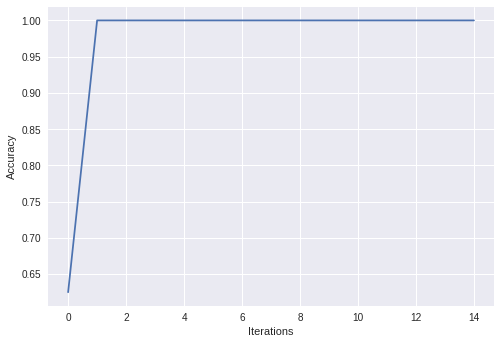

In [52]:
dti, beta, accuracy_final, beta_all, classifiers_all = complete_imp3(15,X,test_data,y)

In [53]:
accuracy_final

[0.625, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# Testing accuracy

In [64]:
def testing(classifiers, Beta_j,X,y, No_of_itr, no_of_Q):
    '''
    here beta_j is the function which is contains the betas in the form - [[beta0,beta1,beta2]itr=1,[beta0,beta1,beta2]itr=2,[beta0,beta1,beta2]itr=3....]
    
    '''
    
    
    
    ## now all the clustering models are stored in classifiers
    
#     X = X_train
#     y = y_train
    
    ## getting y_mod
    T = No_of_itr
    #change labels from 0,1 to -1,1
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)
    
    ## lets do the partitioning to produce domains
    Dti = np.full(8,1/8)
    
    Beta_js = []# the array which will store all the betas
    accuracy_final= []
    for i in range(T):
        beta_j = Beta_j[i]
        predst = classifiers[i].predict(X)
        print(predst)
        final_beta =[]
        # updation of dti and distribution of betas
        for i in range(8):
            if(predst[i]==0):
                final_beta.append(beta_j[0])

            elif(predst[i]==1):
                final_beta.append(beta_j[1])

            else:
                final_beta.append(beta_j[2])
            
        Beta_js.append(final_beta)
            
            # now lets add up the betas and get H(x)
#         print(len())
        final_bin, acc = final_bin_predictions(X,y_mod,Dti,Beta_js)
        accuracy_final.append(acc)
            
#     print(Beta_js)
    import matplotlib.pyplot as plt
    from matplotlib import style
    
    plt.style.use('seaborn')
    plt.plot(list(range(T)), accuracy_final)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Testing Accuracy")
    plt.show()
        
    return Beta_js

[0 2 2 2 2 2 1 0]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]
[1 2 1 2 2 0 1 1]


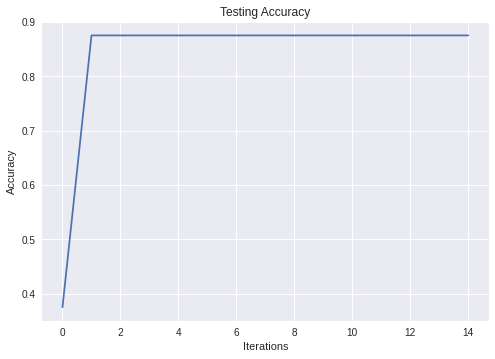

[[-0.6960165774237517,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.7308965887973976,
  -0.6960165774237517],
 [-1.1024821852047155,
  1.0254004279280178,
  -1.1024821852047155,
  1.0254004279280178,
  1.0254004279280178,
  0.833496818954906,
  -1.1024821852047155,
  -1.1024821852047155],
 [-1.0669504127247353,
  1.003095626172872,
  -1.0669504127247353,
  1.003095626172872,
  1.003095626172872,
  0.8816521858296448,
  -1.0669504127247353,
  -1.0669504127247353],
 [-1.003095626172872,
  0.9466465236658571,
  -1.003095626172872,
  0.9466465236658571,
  0.9466465236658571,
  0.8427444909308746,
  -1.003095626172872,
  -1.003095626172872],
 [-0.9849192755825036,
  0.9061304698307093,
  -0.9849192755825036,
  0.9061304698307093,
  0.9061304698307093,
  0.8148428997612468,
  -0.9849192755825036,
  -0.9849192755825036],
 [-0.8989784453074459,
  0.9247847201904312,
  -0.8989784453074459,
  0.9247847201904312,
  0.

In [67]:
testing(classifiers_all, beta_all,X_test,y_test, 15, 6)

In [56]:
beta_all

[[-0.6960165774237517, -0.7308965887973976, -0.01529961808393716],
 [0.833496818954906, -1.1024821852047155, 1.0254004279280178],
 [0.8816521858296448, -1.0669504127247353, 1.003095626172872],
 [0.8427444909308746, -1.003095626172872, 0.9466465236658571],
 [0.8148428997612468, -0.9849192755825036, 0.9061304698307093],
 [0.833496818954906, -0.8989784453074459, 0.9247847201904312],
 [0.8713576466349802, -0.916751998822994, 0.9001324984102453],
 [0.8242250798762817, -0.8713576466349802, 0.8520607916193327],
 [0.8615534757767555, -0.8242250798762817, 0.8615534757767555],
 [0.8427444909308746, -0.8926595787613402, 0.8427444909308746],
 [0.8926595787613401, -0.8334968189549061, 0.8520607916193327],
 [0.8776797143950215, -0.8334968189549061, 0.9153763960589675],
 [0.8528086033717844, -0.8889028469359361, 0.8427444909308746],
 [0.8485194018174314, -0.8615534757767555, 0.8242250798762817],
 [0.8713576466349802, -0.8776797143950215, 0.9153763960589675]]

In [55]:
beta

[[-0.01529961808393716,
  -0.6960165774237517,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.01529961808393716,
  -0.7308965887973976],
 [-1.1024821852047155,
  -1.1024821852047155,
  -1.1024821852047155,
  1.0254004279280178,
  -1.1024821852047155,
  1.0254004279280178,
  0.833496818954906,
  -1.1024821852047155],
 [-1.0669504127247353,
  -1.0669504127247353,
  -1.0669504127247353,
  1.003095626172872,
  -1.0669504127247353,
  1.003095626172872,
  0.8816521858296448,
  -1.0669504127247353],
 [-1.003095626172872,
  -1.003095626172872,
  -1.003095626172872,
  0.9466465236658571,
  -1.003095626172872,
  0.9466465236658571,
  0.8427444909308746,
  -1.003095626172872],
 [-0.9849192755825036,
  -0.9849192755825036,
  -0.9849192755825036,
  0.9061304698307093,
  -0.9849192755825036,
  0.9061304698307093,
  0.8148428997612468,
  -0.9849192755825036],
 [-0.8989784453074459,
  -0.8989784453074459,
  -0.8989784453074459,
  0.9247847201904312